# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 16.11.2024

Мягкий дедлайн: 28.11.2024

Жесткий дедлайн: 02.12.2024

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**:

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [152]:
import numpy as np
import pandas as pd
# import polars as pl
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 30)
# pl.Config().set_tbl_rows(100)
# pl.Config().set_tbl_cols(100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [153]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [154]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**:
y_random содержит дробные числа, потомсу что модель возвращает вероятность принадлежности к классу 1 или 0. А вероятность варьируется от 0 до 1

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [155]:
from sklearn.metrics import average_precision_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.5200
AUC-ROC: 0.5000


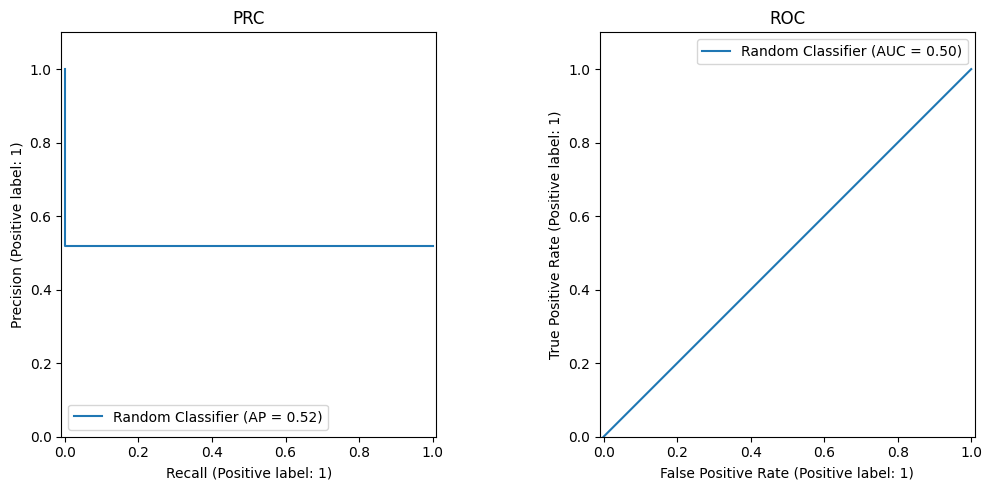

In [156]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    print(classifier_name, 'metrics')
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    print('AUC-PR: %.4f' % average_precision_score(y_true, y_pred))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.4f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [157]:
df_metrics = pd.DataFrame(
    columns=['auc_pr', 'roc_auc_score', 'reg_const']
)
precision, recall, _ = precision_recall_curve(y_test, y_random)
df_metrics.loc['Random Classifier'] = [
      average_precision_score(y_test, y_random),
      roc_auc_score(y_test, y_random),
      0,
]
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.52,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [158]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve, average_precision_score

svm_model = SVC(kernel='linear', probability=True, random_state=42)

param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid,
    scoring='average_precision',
    cv=5,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
best_C = grid_search.best_params_['C']
print(f'Лучший параметр C: {best_C}')

Лучший параметр C: 0.01


In [159]:
best_svm_model = SVC(kernel='linear', C=best_C, probability=True, random_state=42)
best_svm_model.fit(X_train, y_train)

SVC(C=0.01, kernel='linear', probability=True, random_state=42)

In [160]:
y_test_pred_svm = best_svm_model.predict_proba(X_test)[:, 1]
pr_auc = average_precision_score(y_test, y_test_pred_svm)
roc_auc = roc_auc_score(y_test, y_test_pred_svm)

print(f'AUC-PR на тестовой выборке: {pr_auc:.4f}')
print(f'AUC-ROC на тестовой выборке: {roc_auc:.4f}')

AUC-PR на тестовой выборке: 0.8531
AUC-ROC на тестовой выборке: 0.8862


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR

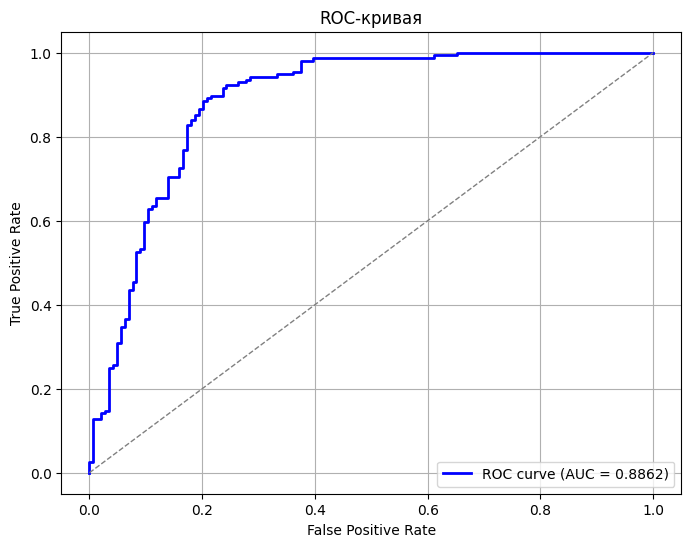

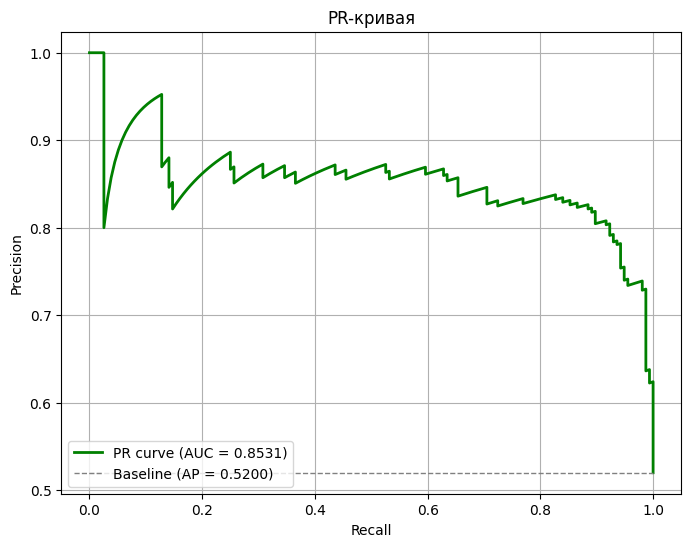

In [161]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

fpr, tpr, thresholds_roc = roc_curve(y_test, y_test_pred_svm)
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_test_pred_svm)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2, label='PR curve (AUC = %0.4f)' % pr_auc)
baseline = y_test.mean()
plt.hlines(baseline, 0, 1, color='gray', lw=1, linestyle='--', label='Baseline (AP = %0.4f)' % baseline)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR-кривая')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

Проанализируйте, как себя ведут обе кривые:
- Что происходит при увеличении порога? Как бы вы это проинтерпретировали?
- Монотонные ли кривые? Как вы это объясните?

Увеличение порога делает модель более "строгой" в отношении предсказания положительного класса. Это приводит к снижению Recall (чувствительности) и увеличению Precision (точности).


**AUC-ROC - монотонная.**
Монотонность AUC-ROC означает, что модель стабильно улучшает (или сохраняет) соотношение между TPR и FPR по мере изменения порога.
AUC-ROC достаточно хорошо работает на сбалансированных данных, где количество положительных и отрицательных классов примерно одинаково.
**AUC-PR - не монотонная.**
Немонотонность AUC-PR может указывать на проблемы с точностью модели при различных порогах.

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [162]:
print(f'AUC-PR на тестовой выборке: {pr_auc:.4f}')
print(f'AUC-ROC на тестовой выборке: {roc_auc:.4f}')

AUC-PR на тестовой выборке: 0.8531
AUC-ROC на тестовой выборке: 0.8862


In [163]:
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.52,0.5,0.0


Предсказание класса модели **Support Vector Machine** работает лучше, чем модель случайного класса. Модель случайного класса наугад предсказывает в какой класс определить объект.

__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [164]:
from sklearn.linear_model import LogisticRegression

# your code here
logistic_model = LogisticRegression(
    penalty='l2',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(
    estimator=logistic_model,
    param_grid=param_grid,
    scoring='average_precision',
    cv=5,
    n_jobs=-1)

grid_search.fit(X_train, y_train)

best_C = grid_search.best_params_['C']
print(f'Лучший гиперпараметр C: {best_C}')

Лучший гиперпараметр C: 0.01


In [165]:
best_logistic_model = LogisticRegression(
    penalty='l2',
    C=best_C,
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)
best_logistic_model.fit(X_train, y_train)

y_test_pred_log = best_logistic_model.predict_proba(X_test)[:, 1]

pr_auc = average_precision_score(y_test, y_test_pred_log)
roc_auc = roc_auc_score(y_test, y_test_pred_log)

print(f'AUC-PR на тестовой выборке: {pr_auc:.4f}')
print(f'AUC-ROC на тестовой выборке: {roc_auc:.4f}')

AUC-PR на тестовой выборке: 0.8605
AUC-ROC на тестовой выборке: 0.8867


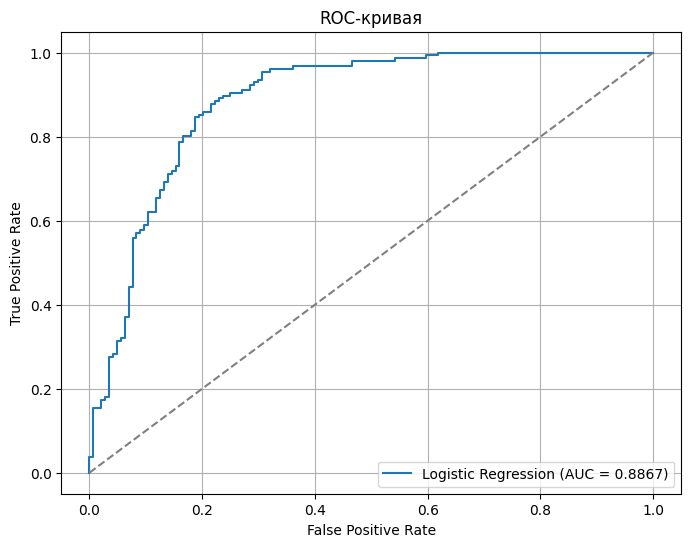

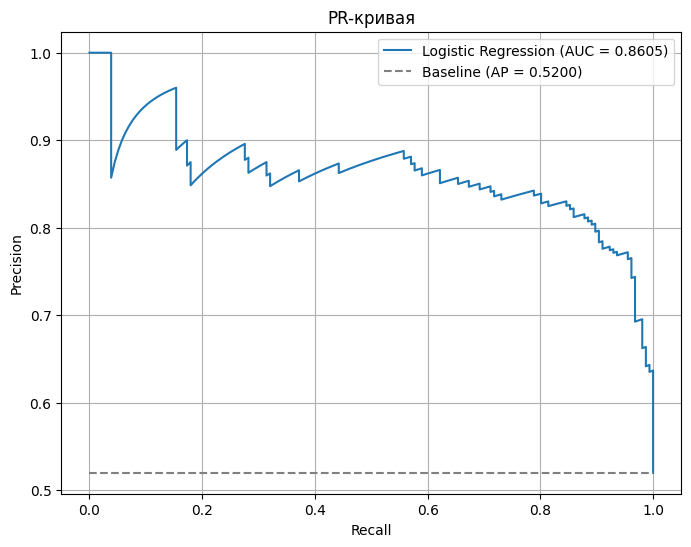

In [166]:
fpr, tpr, thresholds_roc = roc_curve(y_test, y_test_pred_log)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.grid(True)
plt.show()

precision, recall, thresholds_pr = precision_recall_curve(y_test, y_test_pred_log)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Logistic Regression (AUC = {pr_auc:.4f})')
baseline = y_test.mean()
plt.hlines(baseline, 0, 1, colors='grey', linestyles='--', label=f'Baseline (AP = {baseline:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR-кривая')
plt.legend()
plt.grid(True)
plt.show()

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

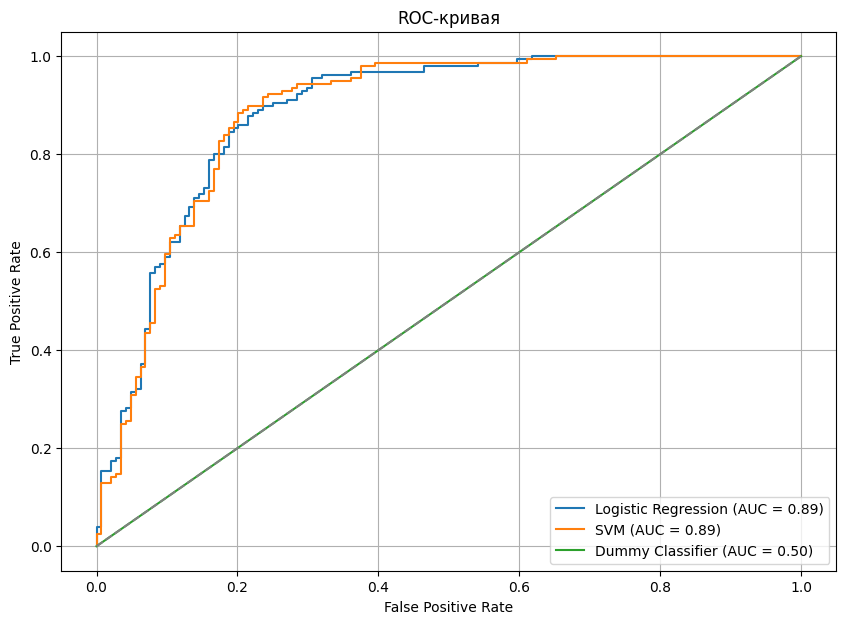

In [167]:
plt.figure(figsize=(10, 7))

for model_name, proba in [("Logistic Regression", y_test_pred_log),
                            ("SVM", y_test_pred_svm),
                            ("Dummy Classifier", y_random)]:
    fpr, tpr, _ = roc_curve(y_test, proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend()
plt.grid(True)

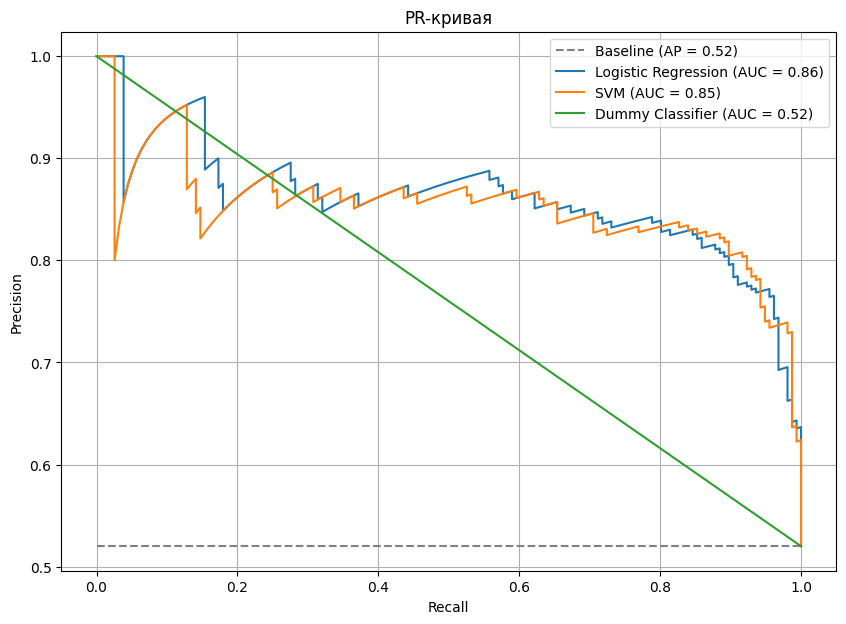

In [168]:
plt.figure(figsize=(10, 7))

baseline = y_test.mean()
plt.hlines(baseline, 0, 1, colors='grey', linestyles='--',
           label=f'Baseline (AP = {baseline:.2f})')


for model_name, proba in [("Logistic Regression", y_test_pred_log),
                            ("SVM", y_test_pred_svm),
                            ("Dummy Classifier", y_random)]:
    precision, recall, _ = precision_recall_curve(y_test, proba)
    pr_auc = average_precision_score(y_test, proba)
    plt.plot(recall, precision, label=f'{model_name} (AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR-кривая')
plt.legend()
plt.grid(True)
plt.show()

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



**Ответ:** Log Reg при построении AUC PR сработал лучше,чем SVM.
При построении AUC ROC различий у двух методов практически нет.

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы. Ниже есть шаблоны, можете воспользоваться ими, либо написать своё

In [169]:
# your code here
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=42)
model = SVC(kernel='linear', random_state=42)
model.fit(X, y)

SVC(kernel='linear', random_state=42)

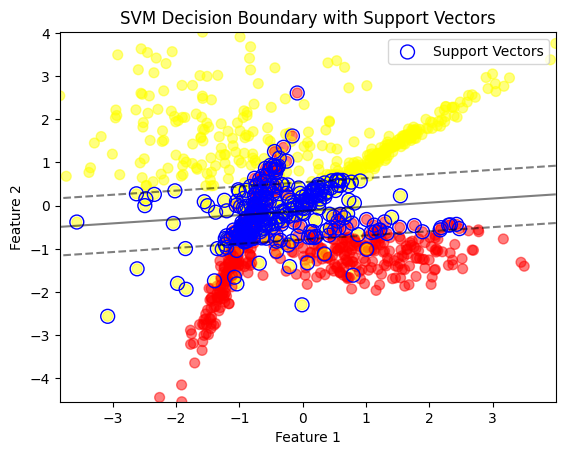

In [170]:
# Функция для визуализации
def plot_svm_2D(X, y, model, plot_support=True):
    xx = np.linspace(X[:, 0].min(), X[:, 0].max(), 30)
    yy = np.linspace(X[:, 1].min(), X[:, 1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    Z = model.decision_function(xy)
    Z = Z.reshape(XX.shape)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', s=50, alpha=0.5)
    if plot_support:
        plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,
                    linewidth=1, edgecolor="blue", facecolors='none', label='Support Vectors')

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('SVM Decision Boundary with Support Vectors')
    plt.legend()
    plt.show()
plot_svm_2D(X, y, model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** Опорные объекты на графике синего цвета, они лежат вблизи опорных векторов и являются наиболее информативными для определения границы разделения классов.


В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

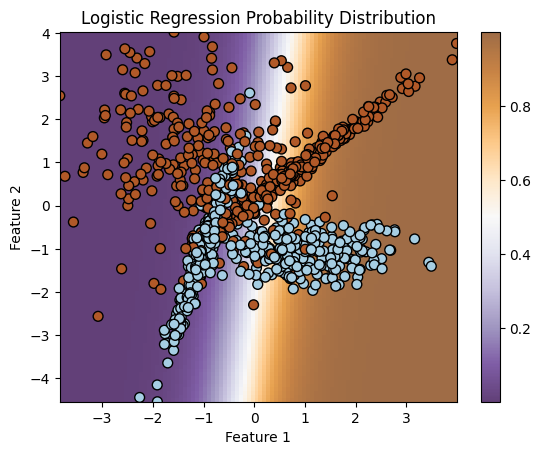

In [171]:
model = LogisticRegression(random_state=42)
model.fit(X, y)

def plot_logreg_2D(X, y, model):
    xx = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    yy = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    Z = model.predict_proba(xy)[:, 1]
    Z = Z.reshape(XX.shape)

    image = plt.imshow(
        Z,
        interpolation='nearest',
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect='auto',
        origin='lower',
        cmap=plt.cm.PuOr_r,
        alpha=0.75
    )

    plt.scatter(
        X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolor='k', s=50
    )

    plt.colorbar(image)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Logistic Regression Probability Distribution')
    plt.show()
plot_logreg_2D(X, y, model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:**
область, где модель не уверена ($p(y=+1|x) = 0.5$), обозначена белым цветом. Эта область представляет разделяющую гиперплоскость модели log reg и позволяет определить объекты коричневого цвета в один класс, объекты фиолетового класса в другой.

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [172]:
import numpy as np
import matplotlib.pyplot as plt

def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()
    plt.show()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

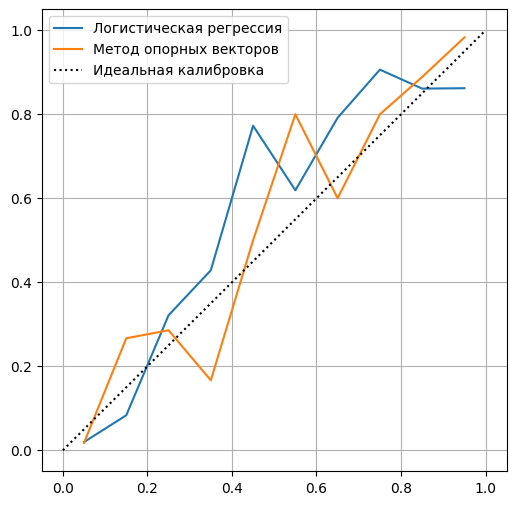

In [173]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss

X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg_preds = logreg.predict_proba(X_test)[:, 1]

svm = SVC(probability=True)
svm.fit(X_train, y_train)
svm_preds = svm.predict_proba(X_test)[:, 1]

def plot_calibration_curve(y_test, preds, label):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    plt.plot(bin_middle_points, bin_real_ratios, label=label)

plt.figure(figsize=(6,6))
plot_calibration_curve(y_test, logreg_preds, 'Логистическая регрессия')
plot_calibration_curve(y_test, svm_preds, 'Метод опорных векторов')
plt.plot([0, 1], [0, 1], 'k:', label='Идеальная калибровка')
plt.ylim([-0.05, 1.05])
plt.legend()
plt.grid()
plt.show()

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии? Подумайте, как это следует из вида кривой

**Ответ:**  кривая SVM совпадает с идеальной калибровкой лишь в нескольких местах. Это говорит о том, что лишь некоторые прогнозируемые вероятности точно соответствуют фактическим вероятностям. В остальных случаях прогнозируемые вероятности объектов отклоняются от фактических вероятностей, что делает откалибровачную кривую для SVM не идеальной и не достатоточно хорошо откалиброванной кривой.

Из формальных способов в этом убедиться есть знакомый вам LogLoss, который напрямую оценивает вероятности,
$$\text{LogLoss} = -\frac{1}{N}\sum_{i} \sum_{k \in {0. 1}}\log p_k[y_i = k]$$
а так же BrierScore, который подсчитывает отклонение между получившейся вероятностью и реальным значением таргета.
$$\text{BrierScore} = \frac{1}{N}\sum_{i} (p_i - y_i)^2$$
Посмотрите на них тоже и сделайте вывод

In [174]:
# your code here
from sklearn.metrics import log_loss, brier_score_loss

lr_logloss = log_loss(y_test, logreg_preds)
lr_brierscore = brier_score_loss(y_test, logreg_preds)
svc_logloss = log_loss(y_test, svm_preds)
svc_brierscore = brier_score_loss(y_test, svm_preds)

print("Logistic Regression:")
print("LogLoss:", lr_logloss)
print("BrierScore:", lr_brierscore)

print("\nSupport Vector Machine:")
print("LogLoss:", svc_logloss)
print("BrierScore:", svc_brierscore)

Logistic Regression:
LogLoss: 0.4348010245397027
BrierScore: 0.13937124628069764

Support Vector Machine:
LogLoss: 0.1885046211346671
BrierScore: 0.05337952321712391


**Вывод**
Исходя из полученных значений метрик LogLoss и BrierScore, можно сделать вывод о том,что модель log reg предсказывает вероятности объектов лучше,чем SVM. Данный вывод прослеживается и на графике, т.к. Log Reg лучше приближен к идеальной калибровочной прямой,чем SVM.

Изучите распределение ответов классификаторов при помощи гистограмм

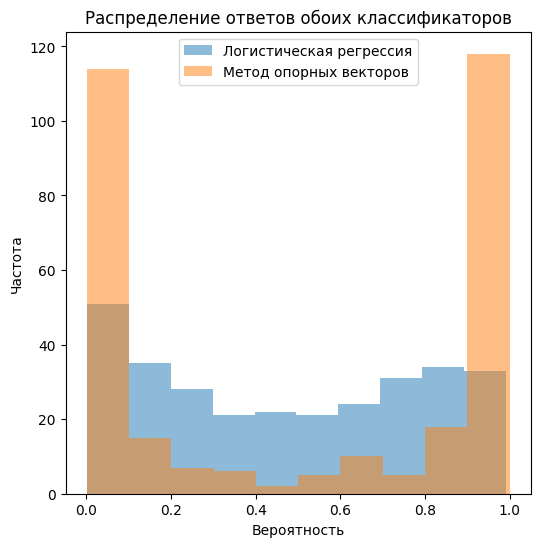

In [175]:
# your code here
plt.figure(figsize=(6,6))
plt.hist(logreg_preds, bins=10, alpha=0.5, label='Логистическая регрессия')
plt.hist(svm_preds, bins=10, alpha=0.5, label='Метод опорных векторов')
plt.title('Распределение ответов обоих классификаторов')
plt.xlabel('Вероятность')
plt.ylabel('Частота')
plt.legend()
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** # your answer here
svm более качественно разделяет объекты на классы. У SVM более 115 объектов точно отнесены к почти 0 вероятности и около 120 объектов к вероятности 1. В логистической регрессии меньше объектов,которые точно относятся к 0 вероятности и к вероятности 1 (55 и 38 объектов соотвественно). Распределение в логитической регресии более равномерное. Точность определения к 0 классу и к 1 первому ниже,чем при использовании SVM.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

LogLoss для калиброванной модели: 0.19633830046151143
BrierScore для калиброванной модели: 0.055072097423759514


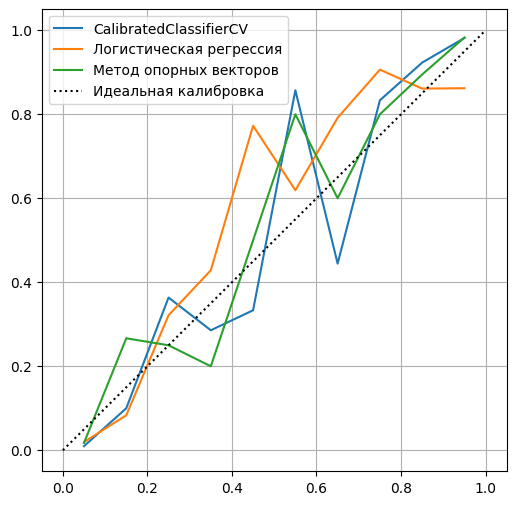

In [27]:
# your code here
import numpy as np
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss, log_loss

svm = SVC(probability=True)
cal_svm = CalibratedClassifierCV(svm, cv=5, method='sigmoid')
cal_svm.fit(X_train, y_train)
cal_svm_preds = cal_svm.predict_proba(X_test)[:, 1]
cal_svm_log_loss = log_loss(y_test, cal_svm.predict_proba(X_test))
cal_svm_brier_score = brier_score_loss(y_test, cal_svm_preds)

print(f"LogLoss для калиброванной модели: {cal_svm_log_loss}")
print(f"BrierScore для калиброванной модели: {cal_svm_brier_score}")

plt.figure(figsize=(6,6))
plot_calibration_curve(y_test, cal_svm_preds, 'CalibratedClassifierCV')
plot_calibration_curve(y_test, logreg_preds, 'Логистическая регрессия')
plot_calibration_curve(y_test, svm_preds, 'Метод опорных векторов')
plt.plot([0, 1], [0, 1], 'k:', label='Идеальная калибровка')
plt.ylim([-0.05, 1.05])
plt.legend()
plt.grid()
plt.show()

**Вопрос:** Улучшились ли калибровочная кривая и качество калибровки?

**Ответ:** Калибровочная кривая улучшилась (визуально CalibratedClassifierCV приблизился к идеальной калибровочной прямой). Качество калибровки немного снизизилось.

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [176]:
from sklearn.isotonic import IsotonicRegression

def cal_proba(train_probs, train_labels, test_probs):
    train_probs = np.array(train_probs)
    train_labels = np.array(train_labels)
    test_probs = np.array(test_probs)
    iso_reg = IsotonicRegression(out_of_bounds='clip')
    iso_reg.fit(train_probs, train_labels)
    cal_test_probs = iso_reg.predict(test_probs)
    return cal_test_probs

In [177]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
svm = SVC(probability=True, random_state=42)
svm.fit(X_train, y_train)
val_probs = svm.predict_proba(X_val)[:, 1]
test_probs = svm.predict_proba(X_test)[:, 1]
cal_isotonic_preds = cal_proba(val_probs, y_val, test_probs)

In [178]:
# Расчет метрик для калиброванных предсказаний
cal_svm_log_loss = log_loss(y_test, cal_isotonic_preds)
cal_svm_brier_score = brier_score_loss(y_test, cal_isotonic_preds)

print(f"LogLoss для калиброванной модели: {cal_svm_log_loss:.4f}")
print(f"BrierScore для калиброванной модели: {cal_svm_brier_score:.4f}")

LogLoss для калиброванной модели: 0.4183
BrierScore для калиброванной модели: 0.0623


# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

*(бесценный шаг)*

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [179]:
import kagglehub
import pandas as pd

path = kagglehub.dataset_download("heeraldedhia/bike-buyers") +  "/bike_buyers.csv"

In [180]:
data = pd.read_csv(path)
data.head()

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000.0,1.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,Europe,42.0,No
1,24107,Married,Male,30000.0,3.0,Partial College,Clerical,Yes,1.0,0-1 Miles,Europe,43.0,No
2,14177,Married,Male,80000.0,5.0,Partial College,Professional,No,2.0,2-5 Miles,Europe,60.0,No
3,24381,Single,NaN,70000.0,0.0,Bachelors,Professional,Yes,1.0,5-10 Miles,Pacific,41.0,Yes
4,25597,Single,Male,30000.0,0.0,Bachelors,Clerical,No,0.0,0-1 Miles,Europe,36.0,Yes


In [181]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                1000 non-null   int64  
 1   Marital Status    993 non-null    object 
 2   Gender            989 non-null    object 
 3   Income            994 non-null    float64
 4   Children          992 non-null    float64
 5   Education         1000 non-null   object 
 6   Occupation        1000 non-null   object 
 7   Home Owner        996 non-null    object 
 8   Cars              991 non-null    float64
 9   Commute Distance  1000 non-null   object 
 10  Region            1000 non-null   object 
 11  Age               992 non-null    float64
 12  Purchased Bike    1000 non-null   object 
dtypes: float64(4), int64(1), object(8)
memory usage: 101.7+ KB


In [182]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                1000 non-null   int64  
 1   Marital Status    993 non-null    object 
 2   Gender            989 non-null    object 
 3   Income            994 non-null    float64
 4   Children          992 non-null    float64
 5   Education         1000 non-null   object 
 6   Occupation        1000 non-null   object 
 7   Home Owner        996 non-null    object 
 8   Cars              991 non-null    float64
 9   Commute Distance  1000 non-null   object 
 10  Region            1000 non-null   object 
 11  Age               992 non-null    float64
 12  Purchased Bike    1000 non-null   object 
dtypes: float64(4), int64(1), object(8)
memory usage: 101.7+ KB


In [183]:
# Разделим на категориальные признаки и числовые
X_numerical = data['Income']# your code here
X_categorical = data[['Marital Status','Gender','Children','Education','Occupation','Home Owner','Cars','Commute Distance','Region','Age']]
other = []

In [184]:
X_categorical = X_categorical.fillna("undefined")

In [185]:
y = data['Purchased Bike']

In [186]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1000 entries, 0 to 999
Series name: Purchased Bike
Non-Null Count  Dtype 
--------------  ----- 
1000 non-null   object
dtypes: object(1)
memory usage: 7.9+ KB


В начале поработаем только с категориальными признаками

In [187]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

In [188]:
X_categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Marital Status    1000 non-null   object
 1   Gender            1000 non-null   object
 2   Children          1000 non-null   object
 3   Education         1000 non-null   object
 4   Occupation        1000 non-null   object
 5   Home Owner        1000 non-null   object
 6   Cars              1000 non-null   object
 7   Commute Distance  1000 non-null   object
 8   Region            1000 non-null   object
 9   Age               1000 non-null   object
dtypes: object(10)
memory usage: 78.2+ KB


#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [189]:
X_categorical

,Marital Status,Gender,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age
0,Married,Female,1.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,Europe,42.0
1,Married,Male,3.0,Partial College,Clerical,Yes,1.0,0-1 Miles,Europe,43.0
2,Married,Male,5.0,Partial College,Professional,No,2.0,2-5 Miles,Europe,60.0
3,Single,undefined,0.0,Bachelors,Professional,Yes,1.0,5-10 Miles,Pacific,41.0
4,Single,Male,0.0,Bachelors,Clerical,No,0.0,0-1 Miles,Europe,36.0
...,...,...,...,...,...,...,...,...,...,...
995,Married,Male,2.0,High School,Professional,Yes,2.0,2-5 Miles,North America,54.0
996,Single,Male,4.0,Graduate Degree,Professional,Yes,0.0,2-5 Miles,North America,35.0
997,Married,undefined,2.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,North America,38.0
998,Single,Male,3.0,Bachelors,Management,No,3.0,1-2 Miles,North America,38.0


In [190]:
import time
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

def preprocess_cat(X_categorical):
    X = np.array(X_categorical)
    X_processed = []
    for row in X:
        processed_row = [str(item) if item is not None else 'Unknown' for item in row]
        X_processed.append(processed_row)
    return np.array(X_processed)
def preprocess_target(y):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    #print("Классы:", le.classes_)
    return y_encoded, le

X_processed = preprocess_cat(X_categorical)
y_encoded, label_encoder = preprocess_target(y)
enc = OrdinalEncoder()
X_encoded = enc.fit_transform(X_processed)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.25, random_state=777, stratify=y
)

start_time = time.time()
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
training_time = time.time() - start_time
y_pred_proba = lr.predict_proba(X_test)[:, 1]

auc_pr = average_precision_score(y_test,y_pred_proba,pos_label=1)


print("\nАUC-PR:", auc_pr)
print("Время обучения:", training_time)


АUC-PR: 0.65238808355612
Время обучения: 0.02225208282470703


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [191]:
import numpy as np
import time
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

def preprocess_cat(X_categorical):
    X = np.array(X_categorical)
    X_processed = []
    for row in X:
        processed_row = [str(item) if item is not None else 'Unknown' for item in row]
        X_processed.append(processed_row)
    return np.array(X_processed)
def preprocess_target(y):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    return y_encoded, le

X_processed = preprocess_cat(X_categorical)
y_encoded, label_encoder = preprocess_target(y)
enc = OneHotEncoder()
X_encoded = enc.fit_transform(X_processed)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.25, random_state=777, stratify=y
)

start_time = time.time()
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
training_time = time.time() - start_time

y_pred_proba = lr.predict_proba(X_test)[:, 1]

auc_pr = average_precision_score(
    y_test,
    y_pred_proba,
    pos_label=1
)
print("\nАUC-PR OH:", auc_pr)
print("Время обучения:", training_time)


АUC-PR OH: 0.692122072751131
Время обучения: 0.016701459884643555


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [192]:
def target_encoding(X_train, X_test, y_train, categorical_columns):
    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()
    for col in categorical_columns:
        encoding_map = {}
        for category in X_train[col].unique():
            category_mask = X_train[col] == category
            target_mean = y_train[category_mask].mean()
            encoding_map[category] = target_mean
        X_train_encoded[col] = X_train[col].map(encoding_map)
        X_test_encoded[col] = X_test[col].map(encoding_map).fillna(y_train.mean())

    return X_train_encoded, X_test_encoded

In [193]:
# повторная предобработка переменных
def preprocess_categorical(X_categorical):
    X = pd.DataFrame(X_categorical)
    for col in X.columns:
        X[col] = X[col].astype(str).fillna('Unknown')
    return X
def preprocess_target(y):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    return y_encoded, le

In [194]:
# your code here
def MeanEncoding(X_categorical, y):
    X = preprocess_categorical(X_categorical)
    categorical_columns = X.columns
    y_encoded, _ = preprocess_target(y)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.25, random_state=777, stratify=y_encoded
    )


    start_time = time.time()

    X_train_encoded, X_test_encoded = target_encoding(
        X_train, X_test, y_train, categorical_columns
    )

    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train_encoded, y_train)


    training_time = time.time() - start_time
    y_pred_proba = lr.predict_proba(X_test_encoded)[:, 1]
    auc_pr = average_precision_score(y_test, y_pred_proba)
    print("Target Encoding:")
    print(f"AUC-PR: {auc_pr:.4f}")
    print(f"Время обучения: {training_time:.4f} секунд")
    return lr, X_train_encoded, X_test_encoded

try:
    model, X_train_encoded, X_test_encoded = MeanEncoding(X_categorical, y)
except Exception as e:
    print("Ошибка:", e)

Target Encoding:
AUC-PR: 0.6509
Время обучения: 0.0411 секунд


##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [195]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

class CountEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_features):
        self.categorical_features = categorical_features
        self.counts_ = {}

    def fit(self, X, y=None):
        for feature in self.categorical_features:
            self.counts_[feature] = X[feature].value_counts()
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for feature in self.categorical_features:
            X_transformed[feature] = X[feature].map(self.counts_[feature]).fillna(0)
        return X_transformed

In [196]:
def preprocess_target(y):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    return y_encoded, le

y_encoded, label_encoder = preprocess_target(y)

X_train, X_test, y_train, y_test = train_test_split(
    X_categorical, y_encoded, test_size=0.25, random_state=777, stratify=y_encoded
)

categorical_columns = X_categorical.columns.tolist()
count_encoder = CountEncoder(categorical_features=categorical_columns)


X_train_encoded = count_encoder.fit_transform(X_train)
X_test_encoded = count_encoder.transform(X_test)


start_time = time.time()
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_encoded, y_train)
training_time = time.time() - start_time

y_pred_proba = lr.predict_proba(X_test_encoded)[:, 1]
auc_pr = average_precision_score(y_test, y_pred_proba)

print("\nAUC-PR Count Encoding:", auc_pr)
print("Время обучения:", training_time)


AUC-PR Count Encoding: 0.5969169014294261
Время обучения: 0.02307581901550293


_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [197]:
def target_encoding_noise(X_train, X_test, y_train, categorical_columns, noise_level=0.01):
    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()

    for col in categorical_columns:
        encoding_map = {}
        for category in X_train[col].unique():
            category_mask = X_train[col] == category
            target_mean = y_train[category_mask].mean()

            # шум - gpt
            noise = np.random.uniform(-noise_level, noise_level)
            encoding_map[category] = target_mean + noise
        X_train_encoded[col] = X_train[col].map(encoding_map)
        X_test_encoded[col] = X_test[col].map(encoding_map).fillna(y_train.mean())

    return X_train_encoded, X_test_encoded

In [198]:
# повторная предобработка переменных
def preprocess_categorical(X_categorical):
    X = pd.DataFrame(X_categorical)
    for col in X.columns:
        X[col] = X[col].astype(str).fillna('Unknown')
    return X
def preprocess_target(y):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    return y_encoded, le

In [199]:
# your code here
def cal_noise(X_categorical, y):
    X = preprocess_categorical(X_categorical)
    categorical_columns = X.columns
    y_encoded, _ = preprocess_target(y)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.25, random_state=777, stratify=y_encoded
    )


    start_time = time.time()

    X_train_encoded, X_test_encoded = target_encoding_noise(
        X_train, X_test, y_train, categorical_columns
    )

    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train_encoded, y_train)


    training_time = time.time() - start_time
    y_pred_proba = lr.predict_proba(X_test_encoded)[:, 1]
    auc_pr = average_precision_score(y_test, y_pred_proba)
    print("Target Encoding:")
    print(f"AUC-PR: {auc_pr:.4f}")
    print(f"Время обучения: {training_time:.4f} секунд")
    return lr, X_train_encoded, X_test_encoded

try:
    model, X_train_encoded, X_test_encoded = cal_noise(X_categorical, y)
except Exception as e:
    print("Ошибка:", e)

Target Encoding:
AUC-PR: 0.6525
Время обучения: 0.0447 секунд


In [52]:
X_train_encoded

,Marital Status,Gender,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age
345,0.424633,0.511546,0.575207,0.533654,0.488482,0.475915,0.601733,0.528463,0.486802,0.503153
540,0.553636,0.511546,0.576801,0.549192,0.440089,0.475915,0.392349,0.462147,0.435962,0.759719
110,0.553636,0.511546,0.575207,0.447137,0.492283,0.487101,0.601733,0.528463,0.486802,0.500287
902,0.553636,0.472546,0.576801,0.533654,0.478131,0.475915,0.601733,0.560317,0.435962,0.348483
15,0.553636,0.511546,0.451728,0.473478,0.492283,0.475915,0.546924,0.528463,0.486802,0.762153
...,...,...,...,...,...,...,...,...,...,...
483,0.424633,0.472546,0.575207,0.549192,0.488482,0.475915,0.601733,0.528463,0.486802,0.242457
375,0.424633,0.511546,0.575207,0.533654,0.478131,0.475915,0.546924,0.528463,0.486802,-0.006042
968,0.553636,0.472546,0.519902,0.323857,0.488482,0.487101,0.392349,0.443720,0.435962,0.352877
756,0.424633,0.472546,0.575207,0.533654,0.478131,0.487101,0.546924,0.528463,0.435962,0.851019


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** # your answer here
Добавление шума позволяет бороться с переобучением модели и улучшать метрики качества.

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times \text{global_mean}}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $\text{global_mean}$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [200]:
def target_encoding_global(X_train, X_test, y_train, categorical_columns, C=10):
    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()
    global_mean = y_train.mean()

    for col in categorical_columns:
        encoding_map = {}
        for category in X_train[col].unique():
            category_mask = X_train[col] == category
            category_count = category_mask.sum()
            target_mean = y_train[category_mask].mean()
            smoothed_mean = (category_count * target_mean + C * global_mean) / (category_count + C)

            encoding_map[category] = smoothed_mean

        X_train_encoded[col] = X_train[col].map(encoding_map)
        X_test_encoded[col] = X_test[col].map(encoding_map).fillna(global_mean)

    return X_train_encoded, X_test_encoded

In [201]:
# повторная предобработка переменных
def preprocess_categorical(X_categorical):
    X = pd.DataFrame(X_categorical)
    for col in X.columns:
        X[col] = X[col].astype(str).fillna('Unknown')
    return X
def preprocess_target(y):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    return y_encoded, le

In [202]:
def GlobalMeanEncoding(X_categorical, y):
    X = preprocess_categorical(X_categorical)
    categorical_columns = X.columns
    y_encoded, _ = preprocess_target(y)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.25, random_state=777, stratify=y_encoded
    )


    start_time = time.time()

    X_train_encoded, X_test_encoded = target_encoding_global(
        X_train, X_test, y_train, categorical_columns
    )

    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train_encoded, y_train)


    training_time = time.time() - start_time
    y_pred_proba = lr.predict_proba(X_test_encoded)[:, 1]
    auc_pr = average_precision_score(y_test, y_pred_proba)
    print("Target Encoding:")
    print(f"AUC-PR: {auc_pr:.4f}")
    print(f"Время обучения: {training_time:.4f} секунд")
    return lr, X_train_encoded, X_test_encoded

try:
    model, X_train_encoded, X_test_encoded = GlobalMeanEncoding(X_categorical, y)
except Exception as e:
    print("Ошибка:", e)

Target Encoding:
AUC-PR: 0.6571
Время обучения: 0.0455 секунд


#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к счётчикам (тем, которые дали наибольший прирост качества).


Проверьте их на наличие выбросов и заполните пропуски средним или медианой, подумайте, что лучше в условиях наших данных



In [203]:
data

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000.0,1.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,Europe,42.0,No
1,24107,Married,Male,30000.0,3.0,Partial College,Clerical,Yes,1.0,0-1 Miles,Europe,43.0,No
2,14177,Married,Male,80000.0,5.0,Partial College,Professional,No,2.0,2-5 Miles,Europe,60.0,No
3,24381,Single,NaN,70000.0,0.0,Bachelors,Professional,Yes,1.0,5-10 Miles,Pacific,41.0,Yes
4,25597,Single,Male,30000.0,0.0,Bachelors,Clerical,No,0.0,0-1 Miles,Europe,36.0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,23731,Married,Male,60000.0,2.0,High School,Professional,Yes,2.0,2-5 Miles,North America,54.0,Yes
996,28672,Single,Male,70000.0,4.0,Graduate Degree,Professional,Yes,0.0,2-5 Miles,North America,35.0,Yes
997,11809,Married,NaN,60000.0,2.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,North America,38.0,Yes
998,19664,Single,Male,100000.0,3.0,Bachelors,Management,No,3.0,1-2 Miles,North America,38.0,No


In [204]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                1000 non-null   int64  
 1   Marital Status    993 non-null    object 
 2   Gender            989 non-null    object 
 3   Income            994 non-null    float64
 4   Children          992 non-null    float64
 5   Education         1000 non-null   object 
 6   Occupation        1000 non-null   object 
 7   Home Owner        996 non-null    object 
 8   Cars              991 non-null    float64
 9   Commute Distance  1000 non-null   object 
 10  Region            1000 non-null   object 
 11  Age               992 non-null    float64
 12  Purchased Bike    1000 non-null   object 
dtypes: float64(4), int64(1), object(8)
memory usage: 101.7+ KB


In [205]:
# your code here
# Визуализация распределения
mean_numeric = data['Income'].mean()

In [206]:
data['Income'].describe()

,Income
count,994.000000
mean,56267.605634
std,31067.817462
min,10000.000000
25%,30000.000000
50%,60000.000000
75%,70000.000000
max,170000.000000


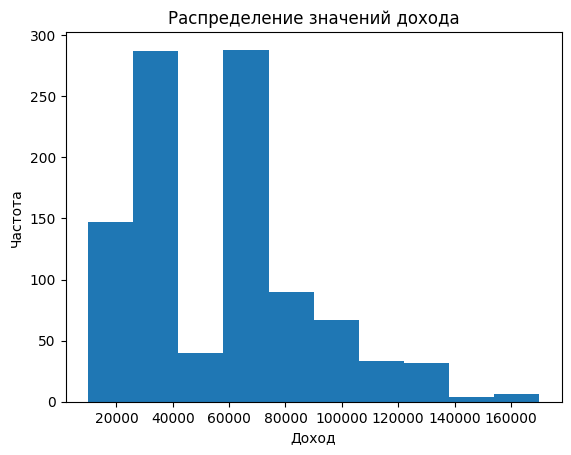

In [207]:
data['Income'].plot.hist(bins=10)
plt.title("Распределение значений дохода")
plt.xlabel("Доход")
plt.ylabel("Частота")
plt.show()

In [208]:
data['Income'] = data['Income'].fillna('mean_numeric')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                1000 non-null   int64  
 1   Marital Status    993 non-null    object 
 2   Gender            989 non-null    object 
 3   Income            1000 non-null   object 
 4   Children          992 non-null    float64
 5   Education         1000 non-null   object 
 6   Occupation        1000 non-null   object 
 7   Home Owner        996 non-null    object 
 8   Cars              991 non-null    float64
 9   Commute Distance  1000 non-null   object 
 10  Region            1000 non-null   object 
 11  Age               992 non-null    float64
 12  Purchased Bike    1000 non-null   object 
dtypes: float64(3), int64(1), object(9)
memory usage: 101.7+ KB


In [209]:
x = data[['Income','Marital Status','Gender','Children','Education','Occupation','Home Owner','Cars','Commute Distance','Region','Age']]

In [210]:
x

,Income,Marital Status,Gender,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age
0,40000.0,Married,Female,1.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,Europe,42.0
1,30000.0,Married,Male,3.0,Partial College,Clerical,Yes,1.0,0-1 Miles,Europe,43.0
2,80000.0,Married,Male,5.0,Partial College,Professional,No,2.0,2-5 Miles,Europe,60.0
3,70000.0,Single,NaN,0.0,Bachelors,Professional,Yes,1.0,5-10 Miles,Pacific,41.0
4,30000.0,Single,Male,0.0,Bachelors,Clerical,No,0.0,0-1 Miles,Europe,36.0
...,...,...,...,...,...,...,...,...,...,...,...
995,60000.0,Married,Male,2.0,High School,Professional,Yes,2.0,2-5 Miles,North America,54.0
996,70000.0,Single,Male,4.0,Graduate Degree,Professional,Yes,0.0,2-5 Miles,North America,35.0
997,60000.0,Married,NaN,2.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,North America,38.0
998,100000.0,Single,Male,3.0,Bachelors,Management,No,3.0,1-2 Miles,North America,38.0


 Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае  может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков. Стало ли лучше?

In [211]:
x['Income'].nunique()

17

In [212]:
def numeric(x, y):
    X = preprocess_categorical(x)
    categorical_columns = X.columns
    y_encoded, _ = preprocess_target(y)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.25, random_state=777, stratify=y_encoded
    )


    start_time = time.time()

    X_train_encoded, X_test_encoded = target_encoding_global(
        X_train, X_test, y_train, categorical_columns
    )

    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train_encoded, y_train)


    training_time = time.time() - start_time
    y_pred_proba = lr.predict_proba(X_test_encoded)[:, 1]
    auc_pr = average_precision_score(y_test, y_pred_proba)
    print("Target Encoding:")
    print(f"AUC-PR: {auc_pr:.4f}")
    print(f"Время обучения: {training_time:.4f} секунд")
    return lr, X_train_encoded, X_test_encoded

try:
    model, X_train_encoded, X_test_encoded = GlobalMeanEncoding(x, y)
except Exception as e:
    print("Ошибка:", e)

Target Encoding:
AUC-PR: 0.6720
Время обучения: 0.0522 секунд


**Ответ** качество модели улучшилось из-за добавления числового признака

> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ # your answer here
**Cчетчики** : позволяют оптимизировать алгоритм, экономить память и данные можно анализировать не в разрезженном виде по сравнению с one hot кодированием.
**Минусы счетчиков** : возможность переобучения модели

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [213]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2024-12-01 20:19:14--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data.1’

adult.data.1            [  <=>               ]   3.79M  16.6MB/s    in 0.2s    

2024-12-01 20:19:14 (16.6 MB/s) - ‘adult.data.1’ saved [3974305]



In [214]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [215]:
x = df.drop('income', axis=1)
y = df['income']

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify=True`.

In [216]:
# your code here
X_train, X_test, y_train, y_test = train_test_split(
        x, y, test_size=0.25, random_state=777, stratify=y
    )

In [217]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  int32 
dtypes: int32(1), int64(6), object(8)
memory usage: 3.6+ MB


Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [218]:
df2 = df.drop('income', axis=1)

In [219]:
categorical = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'hours-per-week', 'native-country']
numerical = ['capital-gain','capital-loss']

In [220]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

categorical = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'hours-per-week', 'native-country']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical)
], remainder='passthrough')

pipeline = Pipeline(steps=[('preprocessor', column_transformer )])
X_processed = pipeline.fit_transform(df2)

print(f"Размерность исходных данных: {df2.shape}")
print(f"Размерность данных после препроцессинга: {X_processed.shape}")

Размерность исходных данных: (32561, 14)
Размерность данных после препроцессинга: (32561, 21935)


In [221]:
X_processed

<32561x21935 sparse matrix of type '<class 'numpy.float64'>'
	with 394963 stored elements in Compressed Sparse Row format>

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [222]:
# your code here
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.25, random_state=777, stratify=y
)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]

pr_auc = average_precision_score(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'AUC-PR на тестовой выборке: {pr_auc:.4f}')

AUC-PR на тестовой выборке: 0.7742


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Допустим, мы хотим оставить только 40 лучших признаков.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, одну из которых, используйте для валидации. Исходную тестовую выборку стоит использовать только для финальной оценки качества после процедуры фильтрации

In [223]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_processed, y, test_size=0.25, random_state=777, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=777, stratify=y_train_val
)

Попробуем сделать это следующими способами:

#### __Задание 9. Встроенные методы (0.5 балла)__

Начнём с отбора признаков с помощью модели. У разных алгоритмов есть разные встроенные способы оценки вклада признаков в предсказание. Как известно, у линейной модели за это отвечают веса, а значит, их модуль можно интерпретировать как важность. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [78]:
# your code here
logreg_full = LogisticRegression(max_iter=1000)
logreg_full.fit(X_train, y_train)

weights = logreg_full.coef_[0]
start_time = time.time()

top_features_indices = np.argsort(np.abs(weights))[-40:]
X_train_sel = X_train[:, top_features_indices]
X_val_sel = X_val[:, top_features_indices]
X_test_sel = X_test[:, top_features_indices]
end_time = time.time()

feature_sel_time = end_time - start_time
print(f"Время отбора признаков: {feature_sel_time:.4f} секунд")

logreg_sel = LogisticRegression(max_iter=10000, solver='saga')
logreg_sel.fit(X_train_sel, y_train)

y_val_pred_proba = logreg_sel.predict_proba(X_val_sel)[:, 1]
val_pr_auc_selected = average_precision_score(y_val, y_val_pred_proba)
print(f"AUC-PR на валидационной выборке (отобранные признаки): {val_pr_auc_selected:.4f}")

y_test_pred_proba = logreg_sel.predict_proba(X_test_sel)[:, 1]
test_pr_auc_selected = average_precision_score(y_test, y_test_pred_proba)
print(f"AUC-PR на тестовой выборке (отобранные признаки): {test_pr_auc_selected:.4f}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Время отбора признаков: 0.0154 секунд
AUC-PR на валидационной выборке (отобранные признаки): 0.5668
AUC-PR на тестовой выборке (отобранные признаки): 0.5561


In [79]:
top_features_indices

array([   42,    34,    37,     3, 21861,    28, 21826, 21917, 21821,
           4,    30, 21749, 21735, 21786, 21750, 21736,     9, 21811,
          10,    36, 21766, 21767, 21780,     5, 21744, 21760,    11,
       21777,    31,     8, 21764,     6, 21795, 21774, 21816,     7,
       21789, 21740, 21761, 21787])

Изменилось ли качество? Как?

**Качество изменилось в худшую сторону**

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Помните, что не все способы одинаково хороши, особенно в условиях наличия выбросов

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [80]:
categorical = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'hours-per-week', 'native-country']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numerical)
])

pipeline = Pipeline(steps=[('preprocessor', column_transformer )])
X_processed = pipeline.fit_transform(df2)

print(f"Размерность исходных данных: {df2.shape}")
print(f"Размерность данных после препроцессинга: {X_processed.shape}")

Размерность исходных данных: (32561, 14)
Размерность данных после препроцессинга: (32561, 21935)


In [81]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_processed, y, test_size=0.25, random_state=777, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=777, stratify=y_train_val
)

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [82]:
# your code here
logreg_full = LogisticRegression(max_iter=1000)
logreg_full.fit(X_train, y_train)

weights = logreg_full.coef_[0]
start_time = time.time()

top_features_indices = np.argsort(np.abs(weights))[-40:]
X_train_sel = X_train[:, top_features_indices]
X_val_sel = X_val[:, top_features_indices]
X_test_sel = X_test[:, top_features_indices]
end_time = time.time()

feature_sel_time = end_time - start_time
print(f"Время отбора признаков: {feature_sel_time:.4f} секунд")

logreg_sel = LogisticRegression(max_iter=1000)
logreg_sel.fit(X_train_sel, y_train)

y_val_pred_proba = logreg_sel.predict_proba(X_val_sel)[:, 1]
val_pr_auc_selected = average_precision_score(y_val, y_val_pred_proba)
print(f"AUC-PR на валидационной выборке (отобранные признаки): {val_pr_auc_selected:.4f}")

y_test_pred_proba = logreg_sel.predict_proba(X_test_sel)[:, 1]
test_pr_auc_selected = average_precision_score(y_test, y_test_pred_proba)
print(f"AUC-PR на тестовой выборке (отобранные признаки): {test_pr_auc_selected:.4f}")

Время отбора признаков: 0.0062 секунд
AUC-PR на валидационной выборке (отобранные признаки): 0.5593
AUC-PR на тестовой выборке (отобранные признаки): 0.5537


In [190]:
top_features_indices

array([13498, 21778,  2923, 11761, 15786,  5684, 13660, 21761, 21740,
       10851,  7163, 16170,     2, 21847,  7115, 21743, 21746,  7759,
       15023,  6312, 21811,  5349, 21876,  6085, 21799,     6, 19868,
        2867,  7752,     5,   700,  5174, 21764,     4,     1, 10240,
       21763,  4917,     3, 21933])

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

Одна из самых простых функция - корреляция между признаком и целевой переменной. Подумайте, какая взаимосвязь между корреляцией и предсказательной способностью модели, и как бы вы использовали информацию о корреляции для отбора признаков

**Ответ:** # your code here

Посчитайте корреляцию каждого признака с таргетом и отфильтруйте 40 признаков исходя из того, что вы описали, после чего замерьте качество и время отбора



In [83]:
var_categorical = list(df[['age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'hours-per-week', 'native-country']])
var_numeric = list(df[['capital-gain','capital-loss']])

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  int32 
dtypes: int32(1), int64(6), object(8)
memory usage: 3.6+ MB


In [85]:
encoder = OneHotEncoder(handle_unknown='ignore')
furnished_enc = encoder.fit_transform(df[['age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'hours-per-week', 'native-country']])

furnished_enc_df = pd.DataFrame(furnished_enc.toarray(), columns=encoder.get_feature_names_out())
furnished_enc_df

,age_17,age_18,age_19,age_20,age_21,age_22,age_23,age_24,age_25,age_26,age_27,age_28,age_29,age_30,age_31,...,native-country_ Nicaragua,native-country_ Outlying-US(Guam-USVI-etc),native-country_ Peru,native-country_ Philippines,native-country_ Poland,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
32557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
32558,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
32559,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [192]:
scaler = StandardScaler()
X_numeric = pd.DataFrame(
    scaler.fit_transform(df[['capital-gain','capital-loss']]),
    columns=var_numeric)

In [193]:
X1_enc = pd.concat([X_numeric, furnished_enc_df], axis=1)

In [94]:
X1_enc = X1_enc.drop('sex_ Male', axis=1)

In [ ]:
X1_enc = pd.concat([X_numeric, furnished_enc_df], axis=1)

In [194]:
#Чтобы видеть что все работает
from tqdm import tqdm

In [195]:
def mart_ret(x_feat=X1_enc, y_targ=df['income']):
  d = pd.concat([x_feat, df['income']], axis=1)
  cor = d.corr()['income'].drop('income')
  return cor

In [196]:
l = len(X1_enc.columns) - 1
batch_size = 100
batch_num = l // batch_size

In [197]:
#получаем батчи с названиями колонок, которые будем передавать в функцию
cols = X1_enc.columns
arr = []
for i in range(0, batch_num + 1):
  arr.append(cols[i*batch_size:(i+1)*batch_size])

In [198]:
test = pd.DataFrame()
for cols in tqdm(arr):
  test = pd.concat([test, mart_ret(X1_enc[cols])], axis=0)

test = test.reset_index()
test['abs_corr'] = test['income'].apply(abs)
top_features = test.sort_values(by=['abs_corr'], ascending=False).head(40).reset_index(drop=True)

100%|██████████| 220/220 [03:56<00:00,  1.08s/it]


In [199]:
# Извлекаем названия топ-40 признаков
top_feature_names = top_features['index'].values

In [200]:
start_time = time.time()
top_feature_indices = [X1_enc.columns.get_loc(c) for c in top_feature_names]

X_train_sel = X_train[:, top_feature_indices]
X_val_sel = X_val[:, top_feature_indices]
X_test_sel = X_test[:, top_feature_indices]

end_time = time.time()
feature_sel_time = end_time - start_time
print(f"Время отбора признаков: {feature_sel_time:.4f} секунд")

Время отбора признаков: 0.0192 секунд


In [ ]:
top_feature_indices

In [201]:
logreg_sel = LogisticRegression(max_iter=1000)
logreg_sel.fit(X_train_sel, y_train)

y_val_pred_proba = logreg_sel.predict_proba(X_val_sel)[:, 1]
val_pr_auc_selected = average_precision_score(y_val, y_val_pred_proba)
print(f"AUC-PR на валидационной выборке (отобранные признаки): {val_pr_auc_selected:.4f}")

y_test_pred_proba = logreg_sel.predict_proba(X_test_sel)[:, 1]
test_pr_auc_selected = average_precision_score(y_test, y_test_pred_proba)
print(f"AUC-PR на тестовой выборке (отобранные признаки): {test_pr_auc_selected:.4f}")

AUC-PR на валидационной выборке (отобранные признаки): 0.6178
AUC-PR на тестовой выборке (отобранные признаки): 0.6135


В качестве еще одной функция можно считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.

In [86]:
def t_statistic(X, y):
    t_stats = []
    for i in range(X.shape[1]):
        col = X[:, i].toarray().flatten() #добавила преобразование разреженных данных в плотный массив
        u_plus = np.mean(col[y == 1])
        u_minus = np.mean(col[y == 0])

        n_plus = np.sum(y == 1)
        n_minus = np.sum(y == 0)

        sigma_plus = np.std(col[y == 1], ddof=1)
        sigma_minus = np.std(col[y == 0], ddof=1)

        t = abs(u_plus - u_minus) / np.sqrt((n_plus * sigma_plus**2 + n_minus * sigma_minus**2) / (n_plus + n_minus))
        t_stats.append(t)
    return np.array(t_stats)

In [87]:
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.25, random_state=777, stratify=y
)

In [88]:
start_time = time.time()
t_stats = t_statistic(X_train, y_train)

top_features_indices = np.argsort(t_stats)[-40:]

X_train_sel = X_train[:, top_features_indices]
X_val_sel = X_val[:, top_features_indices]
X_test_sel = X_test[:, top_features_indices]
end_time = time.time()
feature_sel_time = end_time - start_time
print(f"Время отбора признаков: {feature_sel_time:.4f} секунд")

<ipython-input-86-3b32022d8a8e>:14: RuntimeWarning: invalid value encountered in scalar divide
  t = abs(u_plus - u_minus) / np.sqrt((n_plus * sigma_plus**2 + n_minus * sigma_minus**2) / (n_plus + n_minus))


Время отбора признаков: 74.0176 секунд


In [89]:
logreg_sel = LogisticRegression(max_iter=1000)
logreg_sel.fit(X_train_sel, y_train)

y_val_pred_proba = logreg_sel.predict_proba(X_val_sel)[:, 1]
val_pr_auc_selected = average_precision_score(y_val, y_val_pred_proba)
print(f"AUC-PR на валидационной выборке (отобранные признаки): {val_pr_auc_selected:.4f}")

y_test_pred_proba = logreg_sel.predict_proba(X_test_sel)[:, 1]
test_pr_auc_selected = average_precision_score(y_test, y_test_pred_proba)
print(f"AUC-PR на тестовой выборке (отобранные признаки): {test_pr_auc_selected:.4f}")

AUC-PR на валидационной выборке (отобранные признаки): 0.2408
AUC-PR на тестовой выборке (отобранные признаки): 0.2408


#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем признаки по очереди и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, алгоритм выглядит так:

- $k$ - число признаков, которых мы хотим оставить
- $m$ - число признаков, которых мы выбрасываем на каждой итерации, оно же длина шага

Шаг $i$:
- $F_i$ - набор признаков (равный всему множеству признаков на i=0)
- $M_i$ - их число, в общем случае $\max(k, M_{i-1} - m)$
1. Если признаков осталось ровно $k$, либо метрика стала уменьшаться более, чем на $\epsilon$ — останавливаемся (не наш случай, но так тоже можно)
2. Обучаем модель $a_i$ на наборе $F_i$, после чего оцениваем важность признаков (любым из способов выше или какими-нибудь ещё)
3. Отбираем $\min(M_i - k, m)$ наиболее бесполезных, согласно пункту 2, признаков (берем $m$, если можем, иначе оставляем вплоть до k), удаляем, переходим к следующему шагу

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Подберите длину шага из каких-то соображений (каких, кстати?) и замерьте время работы метода

In [ ]:
X_train

In [ ]:
y

In [90]:
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.25, random_state=777, stratify=y
)

In [91]:
k = 40
m = 500

In [92]:
start_time = time.time()
F = list(range(X_train.shape[1]))
while len(F) > k:
  X_train_best = X_train[:, F]
  X_test_best = X_test[:, F]

  model = LogisticRegression(random_state=777, max_iter=1000)
  model.fit(X_train_best, y_train)

  y_pred_probs = model.predict_proba(X_test_best)[:, 1]
  auc_pr = average_precision_score(y_test, y_pred_probs)

  feature_importances = abs(model.coef_[0])
  importance_dict = {F[i]: feature_importances[i] for i in range(len(F))}
  sorted_features = sorted(importance_dict, key=importance_dict.get)
  F = F[:-min(len(F) - k, m)]
  X_train_end = X_train[:, F]
  X_test_end = X_test[:, F]

  final_model = LogisticRegression(random_state=777, max_iter=1000)
  final_model.fit(X_train_end, y_train)

  y_pred_probs = final_model.predict_proba(X_test_end)[:, 1]
  auc_pr = average_precision_score(y_test, y_pred_probs)

  end_time = time.time()
  print(f"Итоговое количество признаков: {len(F)}")
  print(f"AUC-PR на тестовой выборке: {auc_pr}")
  print(f"Время работы метода: {end_time - start_time:.2f} секунд")

Итоговое количество признаков: 21435
AUC-PR на тестовой выборке: 0.45582433550097085
Время работы метода: 12.82 секунд
Итоговое количество признаков: 20935
AUC-PR на тестовой выборке: 0.45497767681359735
Время работы метода: 15.80 секунд
Итоговое количество признаков: 20435
AUC-PR на тестовой выборке: 0.4553145892927456
Время работы метода: 19.35 секунд
Итоговое количество признаков: 19935
AUC-PR на тестовой выборке: 0.454413930175474
Время работы метода: 23.31 секунд
Итоговое количество признаков: 19435
AUC-PR на тестовой выборке: 0.45307432851533935
Время работы метода: 25.03 секунд
Итоговое количество признаков: 18935
AUC-PR на тестовой выборке: 0.45268464346300424
Время работы метода: 26.99 секунд
Итоговое количество признаков: 18435
AUC-PR на тестовой выборке: 0.45269004037773036
Время работы метода: 28.74 секунд
Итоговое количество признаков: 17935
AUC-PR на тестовой выборке: 0.4515831341962774
Время работы метода: 30.50 секунд
Итоговое количество признаков: 17435
AUC-PR на тесто

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ самые полезные признаки в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [93]:
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.25, random_state=777, stratify=y
)

In [94]:
F = list(range(X_train.shape[1]))
selected_features = []

while len(selected_features) < k:
    if not selected_features:
        selected_features.append(F[0])
    else:
        X_train_subset = X_train[:, selected_features]
        X_test_subset = X_test[:, selected_features]
        if X_train_subset.shape[1] == 0:
            break

        model = LogisticRegression(random_state=777, max_iter=1000)
        model.fit(X_train_subset, y_train)

        y_pred_probs = model.predict_proba(X_test_subset)[:, 1]
        auc_pr = average_precision_score(y_test, y_pred_probs)

        feature_importances = abs(model.coef_[0])
        importance_dict = {F[i]: feature_importances[i] for i in range(len(selected_features))}
        best_feature = max(importance_dict, key=importance_dict.get)
        selected_features.append(best_feature)

X_train_final = X_train[:, selected_features]
X_test_final = X_test[:, selected_features]

final_model = LogisticRegression(random_state=777, max_iter=1000)
final_model.fit(X_train_final, y_train)

final_y_pred_probs = final_model.predict_proba(X_test_final)[:, 1]
final_auc_pr = average_precision_score(y_test, final_y_pred_probs)

end_time = time.time()
print(f"Итоговое количество признаков: {len(selected_features)}")
print(f"AUC-PR на тестовой выборке: {final_auc_pr}")
print(f"Время работы метода: {end_time - time.time():.2f} секунд")

Итоговое количество признаков: 40
AUC-PR на тестовой выборке: 0.24365987071108902
Время работы метода: -0.00 секунд


Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** # your code here

**Встроенные методы** : AUC-PR на валидационной выборке (отобранные признаки): 0.5593. AUC-PR на тестовой выборке (отобранные признаки): 0.5537. Модель достаточно слабо предсказывает класс объектов.

**Методы фильтрации** : AUC-PR на валидационной выборке (отобранные признаки): 0.6178. AUC-PR на тестовой выборке (отобранные признаки): 0.6135. Модель средне предсказывает класс объектов.

**Методы фильтрации (t-статистика)** : AUC-PR на валидационной выборке (отобранные признаки): 0.2408. AUC-PR на тестовой выборке (отобранные признаки): 0.2408. Модель слабо предсказывает признаки. Возможно дело в том,что необходимо расширить количество лучших признаков, чтобы улучшить качество модели.

**Метод обертки** : Итоговое количество признаков: 40
AUC-PR на тестовой выборке: 0.366256917714368
Время работы метода: 76.69 секунд.
Работает достаточно долго, но хорошо перебирает признаки и удаляет лишнее.

**Лучшим методом получился метод фильтрации**



# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [224]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2024-12-01 20:20:43--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank-additional.zip.2’

bank-additional.zip     [ <=>                ] 434.15K  2.66MB/s    in 0.2s    

2024-12-01 20:20:44 (2.66 MB/s) - ‘bank-additional.zip.2’ saved [444572]

Archive:  bank-additional.zip
replace bank-additional/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [226]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [227]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте наиболее подходящие с вашей точки зрения параметры и их значения (`shuffle`, `stratify`, число фолдов, ...). По кросс-валидации у вас получится несколько вариантов обучающей и тестовой выборки. Для удобства можно воспользоваться шаблоном ниже, который по ходу выполнения задания будет обрастать функционалом. Как обычно, это необязательно, но сохранять результаты экспериментов очень и очень желательно, в конце мы будем их сравнивать

In [228]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=None,
    shuffle=True,
    model_class=LogisticRegression,
    model_params={},
    categorical_features=None
):
    metrics = []
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):
        if isinstance(X, pd.DataFrame):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        else:
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

        pipeline = Pipeline([
            ('classifier', model_class(**model_params))
        ])


        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        metric_dict = {
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred, average='weighted'),
            "recall": recall_score(y_test, y_pred, average='weighted'),
            "f1": f1_score(y_test, y_pred, average='weighted')
        }
        metrics.append(metric_dict)
    return pd.DataFrame(metrics)

Выберите метрику классификации, которая вам кажется подходящей, и обучите логистическую регрессию на каждой обучающей выборке (закодируйте категориальные признаки способом, который выше вам понравился больше всех, отнормируйте числовые, гиперпараметры оставьте по умолчанию), сделайте предсказания для соответствующих тестовых выборок, выведите результаты

In [229]:
# добавила масштабирование признаков
def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=None,
    shuffle=True,
    model_class=LogisticRegression,
    model_params={},
    categorical_features=None
):
    metrics = []
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    if categorical_features is None:
        categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    numeric_features = X.select_dtypes(include=['number']).columns.tolist()
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
            ('num', StandardScaler(), numeric_features)
        ]
    )
    for train_index, test_index in kf.split(X):
        if isinstance(X, pd.DataFrame):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        else:
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model_class(**model_params))
        ])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        metric_dict = {
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred, average='weighted'),
            "recall": recall_score(y_test, y_pred, average='weighted'),
            "f1": f1_score(y_test, y_pred, average='weighted')
        }
        metrics.append(metric_dict)
    return pd.DataFrame(metrics)

if __name__ == "__main__":
    results = cross_validate(X, y, n_splits=5, random_state=42, shuffle=True)
    print(results)

   accuracy  precision    recall        f1
0  0.897062   0.876842  0.897062  0.873160
1  0.902889   0.886386  0.902889  0.881340
2  0.896941   0.878510  0.896941  0.875754
3  0.905548   0.888084  0.905548  0.884500
4  0.898143   0.880398  0.898143  0.874042


Допустим, работники вашего колл-центра получают за один звонок клиенту 2 доллара. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить.

В качестве бизнес-метрики в нашей задаче мы будем считать прибыль aka `profit`, соответственно лучшую модель будем выбирать исходя из этого.
Посчитайте на всех тестовых выборках выручку и сохраните результаты для бизнес-метрики вместе с предыдущей метрикой, которую вы выбрали

Ответьте на вопросы:
- Сколько денег вы в среднем заработаете?
- Какое получилось стандартное отклонение профита?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?
- Пропорциональна ли бизнес-метрика выбранной метрике классификации?

In [230]:
def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=None,
    shuffle=True,
    model_class=LogisticRegression,
    model_params={},
    categorical_features=None
):
    metrics = []
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    if categorical_features is None:
        categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    numeric_features = X.select_dtypes(include=['number']).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
            ('num', StandardScaler(), numeric_features)
        ]
    )

    for train_index, test_index in kf.split(X):
        if isinstance(X, pd.DataFrame):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        else:
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model_class(**model_params))
        ])
        pipeline.fit(X_train, y_train)

        y_pred = pipeline.predict(X_test)

        metric_dict = {
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred, average='weighted'),
            "recall": recall_score(y_test, y_pred, average='weighted'),
            "f1": f1_score(y_test, y_pred, average='weighted')
        }

        cost_per_call = 2
        revenue_per_client = 10
        calls_made = np.sum(y_pred == 1)
        successful_calls = np.sum((y_pred == 1) & (y_test == 1))
        profit = (successful_calls * revenue_per_client) - (calls_made * cost_per_call)
        metric_dict["profit"] = profit
        metrics.append(metric_dict)

    return pd.DataFrame(metrics)

if __name__ == "__main__":
    results = cross_validate(X, y, n_splits=5, random_state=42, shuffle=True)
    mean_profit = results['profit'].mean()
    std_profit = results['profit'].std()
    n_splits=5
    mean_calls_made = results.apply(lambda row: np.sum(row['f1'] * len(y) / n_splits), axis=1).mean()
    money_to_operators = mean_calls_made * 2
    correlation = results['profit'].corr(results['f1'])
    print("Метрики:")
    print(results)
    print(f"Cредний заработок: {mean_profit:.2f} доллара")
    print(f"Стандартное отклонение профита: {std_profit:.2f} доллара")
    print(f"Процент оператора колл-центра: {money_to_operators:.2f} доллара")
    print(f"Корреляция между метрикой и выручкой : {correlation:.2f}")

Метрики:
   accuracy  precision    recall        f1  profit
0  0.897062   0.876842  0.897062  0.873160    1356
1  0.902889   0.886386  0.902889  0.881340    1550
2  0.896941   0.878510  0.896941  0.875754    1652
3  0.905548   0.888084  0.905548  0.884500    1418
4  0.898143   0.880398  0.898143  0.874042    1454
Cредний заработок: 1486.00 доллара
Стандартное отклонение профита: 116.40 доллара
Процент оператора колл-центра: 14461.26 доллара
Корреляция между метрикой и выручкой : 0.07


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента (для разбиения на фолды разумеется оставьте). Что получилось?

In [235]:
# your code here
def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=None,
    shuffle=True,
    model_class=LogisticRegression,
    model_params={},
    categorical_features=None,
    threshold=0.5
):
    metrics = []
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    if categorical_features is None:
        categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    numeric_features = X.select_dtypes(include=['number']).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
            ('num', StandardScaler(), numeric_features)
        ]
    )
    for train_index, test_index in kf.split(X):
        if isinstance(X, pd.DataFrame):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        else:
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model_class(**model_params))
        ])
        pipeline.fit(X_train, y_train)

        y_pred = pipeline.predict(X_test)

        metric_dict = {
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred, average='weighted'),
            "recall": recall_score(y_test, y_pred, average='weighted'),
            "f1": f1_score(y_test, y_pred, average='weighted')
        }
        cost_per_call = 2
        calls_made = np.sum(y_pred == 1)
        successful_calls = np.sum((y_pred == 1) & (y_test == 1))

  # генерация случайного дохода для успешных звонков
        revenue_per_client = np.random.uniform(0, 20, successful_calls)
        total_revenue = np.sum(revenue_per_client)
        profit = total_revenue - (calls_made * cost_per_call)
        metric_dict["profit"] = profit

        metrics.append(metric_dict)
    return pd.DataFrame(metrics)

if __name__ == "__main__":
    results = cross_validate(X, y, n_splits=5, random_state=42, shuffle=True)
    mean_profit = results['profit'].mean()
    std_profit = results['profit'].std()
    n_splits=5
    mean_calls_made = results.apply(lambda row: np.sum(row['f1'] * len(y) / n_splits), axis=1).mean()
    money_to_operators = mean_calls_made * 2
    correlation = results['profit'].corr(results['f1'])
    print("Метрики:")
    print(results)
    print(f"Cредний заработок: {mean_profit:.2f} доллара")
    print(f"Стандартное отклонение профита: {std_profit:.2f} доллара")
    print(f"Процент оператора колл-центра: {money_to_operators:.2f} доллара")
    print(f"Корреляция между метрикой и выручкой : {correlation:.2f}")

Метрики:
   accuracy  precision    recall        f1       profit
0  0.897062   0.876842  0.897062  0.873160  1449.732207
1  0.902889   0.886386  0.902889  0.881340  1483.094557
2  0.896941   0.878510  0.896941  0.875754  1630.469794
3  0.905548   0.888084  0.905548  0.884500  1348.572309
4  0.898143   0.880398  0.898143  0.874042  1546.255020
Cредний заработок: 1491.62 доллара
Стандартное отклонение профита: 105.54 доллара
Процент оператора колл-центра: 14461.26 доллара
Корреляция между метрикой и выручкой : -0.62


**Разброс выручки по каждому фолду увеличился, прибыль компании увеличилась, заработная плата оператора колл-центра - const**

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента

Лучший коэффициент регуляризации: 166.81005372000558
Максимальная средняя прибыль: 1567.82


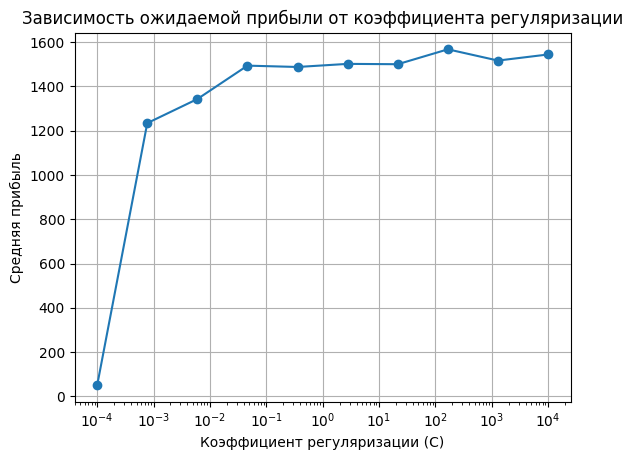

In [232]:
# your code here
def optimize_regularization(X, y, regularization_values, n_splits=5, random_state=42, shuffle=True):
    best_c = None
    max_mean_profit = -np.inf
    mean_profits = []

    for c in regularization_values:
        model_params = {'C': c}
        results = cross_validate(X, y, n_splits=n_splits, random_state=random_state, shuffle=shuffle, model_params=model_params)
        mean_profit = results['profit'].mean()
        mean_profits.append(mean_profit)

        if mean_profit > max_mean_profit:
            max_mean_profit = mean_profit
            best_c = c

    return best_c, max_mean_profit, mean_profits

if __name__ == "__main__":
    regularization_values = np.logspace(-4, 4, 10)
    best_c, max_mean_profit, mean_profits = optimize_regularization(X, y, regularization_values)
    print(f"Лучший коэффициент регуляризации: {best_c}")
    print(f"Максимальная средняя прибыль: {max_mean_profit:.2f}")

    import matplotlib.pyplot as plt
    plt.plot(regularization_values, mean_profits, marker='o')
    plt.xscale('log')
    plt.xlabel('Коэффициент регуляризации (C)')
    plt.ylabel('Средняя прибыль')
    plt.title('Зависимость ожидаемой прибыли от коэффициента регуляризации')
    plt.grid(True)
    plt.show()

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

Запуск 1/5
Запуск 2/5
Запуск 3/5
Запуск 4/5
Запуск 5/5
Результаты всех запусков:
Запуск 1: Лучший коэффициент регуляризации: 1291.5496650148827, Максимальная средняя прибыль: 1538.65
Запуск 2: Лучший коэффициент регуляризации: 1291.5496650148827, Максимальная средняя прибыль: 1525.00
Запуск 3: Лучший коэффициент регуляризации: 10000.0, Максимальная средняя прибыль: 1561.02
Запуск 4: Лучший коэффициент регуляризации: 2.782559402207126, Максимальная средняя прибыль: 1506.22
Запуск 5: Лучший коэффициент регуляризации: 166.81005372000558, Максимальная средняя прибыль: 1524.53


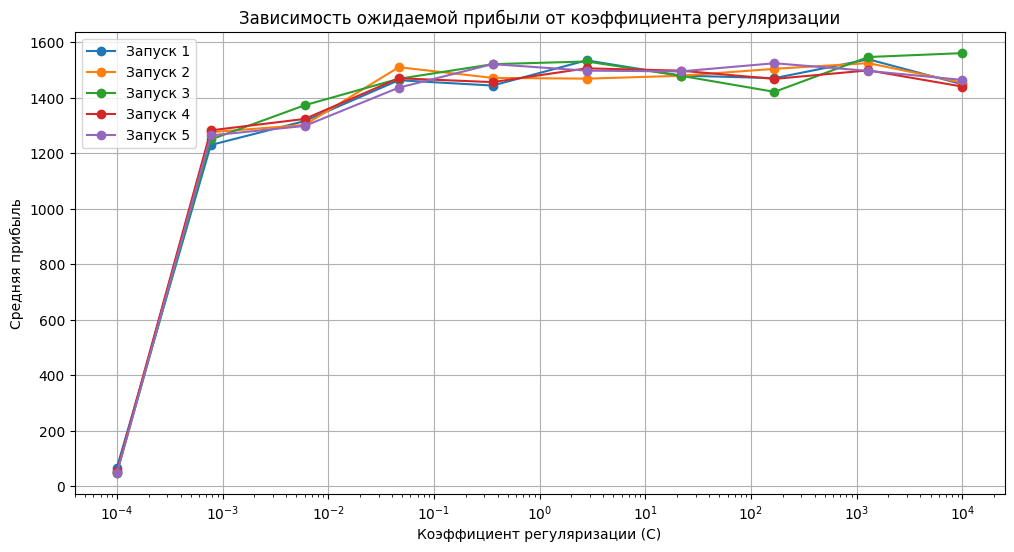

In [233]:
# your code here, для постепенной отрисовки писала запрос
if __name__ == "__main__":
    regularization_values = np.logspace(-4, 4, 10)
    num_runs = 5
    best_c_values = []
    max_mean_profits = []
    all_mean_profits = []
    for run in range(num_runs):
        print(f"Запуск {run + 1}/{num_runs}")
        best_c, max_mean_profit, mean_profits = optimize_regularization(X, y, regularization_values)
        best_c_values.append(best_c)
        max_mean_profits.append(max_mean_profit)
        all_mean_profits.append(mean_profits)
    print("Результаты всех запусков:")
    for i in range(num_runs):
        print(f"Запуск {i + 1}: Лучший коэффициент регуляризации: {best_c_values[i]}, Максимальная средняя прибыль: {max_mean_profits[i]:.2f}")

    plt.figure(figsize=(12, 6))
    for i in range(num_runs):
        plt.plot(regularization_values, all_mean_profits[i], label=f'Запуск {i + 1}', marker='o')

    plt.xscale('log')
    plt.xlabel('Коэффициент регуляризации (C)')
    plt.ylabel('Средняя прибыль')
    plt.title('Зависимость ожидаемой прибыли от коэффициента регуляризации')
    plt.legend()
    plt.grid(True)
    plt.show()

Чем выше коэффициент регуляризации,тем выше максимальная прибыль.

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ # your answer here



Важнее  precision, так как в данной задаче необходимо минимизировать расходы на звонки с клиентами, которые не принесут доход, тем самым оптимизировать доходы компании

> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот. Добавьте новую ML-метрику в ваш CV-пайплайн, найдите такой порог, при котором бизнес-метрика максимальна, и проверьте, связана ли новая ML метрика с профитом

Постройте график зависимости прибыли от порога бинаризации. Выделите наилучший порог




In [242]:
def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=None,
    shuffle=True,
    model_class=LogisticRegression,
    model_params={},
    categorical_features=None,
    thresholds=np.arange(0, 1.01, 0.01)
):
    metrics = []
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    if categorical_features is None:
        categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    numeric_features = X.select_dtypes(include=['number']).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
            ('num', StandardScaler(), numeric_features)
        ]
    )
    for train_index, test_index in kf.split(X):
        if isinstance(X, pd.DataFrame):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        else:
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model_class(**model_params))
        ])
        pipeline.fit(X_train, y_train)

        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        profits = []
        for threshold in thresholds:
            y_pred = (y_pred_proba >= threshold).astype(int)
            calls_made = np.sum(y_pred == 1)
            successful_calls = np.sum((y_pred == 1) & (y_test == 1))

            revenue_per_client = np.random.uniform(0, 20, successful_calls)
            total_revenue = np.sum(revenue_per_client)
            profit = total_revenue - (calls_made * 2)
            profits.append(profit)

        best_threshold = thresholds[np.argmax(profits)]
        y_pred = (y_pred_proba >= best_threshold).astype(int)

        metric_dict = {
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred, average='weighted'),
            "recall": recall_score(y_test, y_pred, average='weighted'),
            "f1": f1_score(y_test, y_pred, average='weighted'),
            "best_threshold": best_threshold,
            "profit": profits[np.argmax(profits)]
        }

        metrics.append(metric_dict)
    return pd.DataFrame(metrics)
metrics = cross_validate(X, y)

best_threshold = metrics['best_threshold'].iloc[np.argmax(metrics['profit'])]
print(f'Наилучший порог: {best_threshold:.2f}')

Наилучший порог: 0.18


__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ # your answer here

Наконец, чтобы точнее понять, что наша модель лучше исходной, посчитайте среднее и стандартное отклонение по фолдам бизнес-метрики для оптимизированной модели (гиперпараметры + порог) и дефолтной логистической регрессии. Проверьте, действительно ли удалось добиться значимого изменения прибыли — примените какой-либо статистический тест (например, парный t-критерий с $\alpha=0.95$) к метрике, полученной двумя этими моделями

In [247]:
def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=None,
    shuffle=True,
    model_class=LogisticRegression,
    model_params={},
    categorical_features=None,
    threshold=0.5
):
    metrics = []
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    if categorical_features is None:
        categorical_features = X.select_dtypes(include=['object']).columns.tolist()
    numeric_features = X.select_dtypes(include=['number']).columns.tolist()

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
            ('num', StandardScaler(), numeric_features)
        ]
    )
    for train_index, test_index in kf.split(X):
        if isinstance(X, pd.DataFrame):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        else:
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model_class(**model_params))
        ])
        pipeline.fit(X_train, y_train)

        y_pred = pipeline.predict(X_test)

        metric_dict = {
            "accuracy": accuracy_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred, average='weighted'),
            "recall": recall_score(y_test, y_pred, average='weighted'),
            "f1": f1_score(y_test, y_pred, average='weighted')
        }
        cost_per_call = 2
        calls_made = np.sum(y_pred == 1)
        successful_calls = np.sum((y_pred == 1) & (y_test == 1))

  # генерация случайного дохода для успешных звонков
        revenue_per_client = np.random.uniform(0, 20, successful_calls)
        total_revenue = np.sum(revenue_per_client)
        profit = total_revenue - (calls_made * cost_per_call)
        metric_dict["profit"] = profit

        metrics.append(metric_dict)
    return pd.DataFrame(metrics)

In [248]:
optim_model_params = {'C': 10, 'max_iter': 10000}
optim_threshold = 0.35
optim_results = cross_validate(X, y, n_splits=5, random_state=42, shuffle=True, model_params=optim_model_params, threshold=optim_threshold)
default_results = cross_validate(X, y, n_splits=5, random_state=42, shuffle=True)

optim_mean_profit = optim_results['profit'].mean()
optim_std_profit = optim_results['profit'].std()
default_mean_profit = default_results['profit'].mean()
default_std_profit = default_results['profit'].std()

print(f'Оптимизированная модель: средняя прибыль = {optim_mean_profit:.2f}, стандартное отклонение = {optim_std_profit:.2f}')
print(f'Дефолтная логистическая регрессия: средняя прибыль = {default_mean_profit:.2f}, стандартное отклонение = {default_std_profit:.2f}')

t_stat, p_value = stats.ttest_rel(optim_results['profit'], default_results['profit'])
print(f'Парный t-критерий: t-статистика = {t_stat:.4f}, p-значение = {p_value:.4f}')

if p_value < 0.05:
    print('Отказываем нулевую гипотезу: средние прибыли оптимизированной модели и дефолтной логистической регрессии различаются')
else:
    print('Не можем отказать нулевую гипотезу: средние прибыли оптимизированной модели и дефолтной логистической регрессии не различаются')

Оптимизированная модель: средняя прибыль = 1486.82, стандартное отклонение = 107.40
Дефолтная логистическая регрессия: средняя прибыль = 1487.05, стандартное отклонение = 81.96
Парный t-критерий: t-статистика = -0.0095, p-значение = 0.9929
Не можем отказать нулевую гипотезу: средние прибыли оптимизированной модели и дефолтной логистической регрессии не различаются


Чтобы значения различались необходимо грамотно настроить гиперпараметры

# __Бонусная часть. Многоклассовая классификация__ (1.5 балла)

Как известно, некоторые задачи не ограничиваются всего лишь двумя классами. На лекции вы проходили несколько способов обобщения линейных моделей на этот случай: One-vs-Rest и One-vs-One. Ниже мы посмотрим, в чём преимущества и недостатки обоих подходов, а так же попробуем ещё один чуть более экзотический метод

#### **Задание 14. One-vs-Rest vs One-vs-One** (0.5 балла)

В качестве [датасета](https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data) здесь и ниже мы будем брать очень жизненные и актуальные данные о том, доучится студент или нет, в зависимости от курсов, возраста, гендера и прочих (не)осуждаемых признаков.

In [ ]:
import kagglehub

path = kagglehub.dataset_download("thedevastator/higher-education-predictors-of-student-retention") + "/dataset.csv"

features = ["Marital status", "Course", "Nacionality", "Gender", "Age at enrollment"]
target = "Target"

Будем смотреть только какое-то подмножество наиболее весёлых факторов. От вас по классике потребуется их преобразовать, в зависимости от того, числовые они или категориальные и **закодировать таргет чиселками!!!**

In [ ]:
# your code here

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=228, shuffle=True, test_size=0.2)

Ваш следующий шаг - посмотреть, каким образом в `sklearn` реализованы OvR и OvO, обучить таким образом логистическую регрессию с `max_iter=10000`, далее выбрать какую-то метрику (и её усреднение, его выбор тоже аргументируйте), и сравнить следующие параметры:
- число классификаторов
- скорость обучения
- качество модели

Также сохраните куда-нибудь предсказания вероятностей у каждой из моделей. Это можно сделать не одним способом, но возможно вам чуть с этим поможет следующий пункт


In [ ]:
# your code here

Как вы объясните полученные результаты?

__Ответ:__ # your code here

#### __Задание 15. Softmax регрессия__ (1 балл)

Однако любознательные машинисты могут задаться вопросом "А зачем нам вся эта шляпа, если у сигмоиды есть обобщение на случай многоклассовой классификации?" Если вам понравилось считать градиенты в прошлом дз, или вам нравится обучать нейросети, этот пункт для вас. Здесь мы попробуем построить одну-единственную модель, которая будет всё предсказывать, а также сравним с вариантами выше

Начнём с подсчёта лосса. Вспомним, что логистическая функция потерь это частный случай кросс-энтропии, её и будем пытаться оптимизировать.

$$
\text{CE}(X, y) = -\frac{1}{N}\sum_i \sum_k [y_i = k] \log p(x_i = k)
$$
Вероятности в данном случае будем считать при помощи софтмакса, что есть общий случай сигмоиды

$$
p(x_i) = \text{Softmax}(a(x_i)); \quad
\text{Softmax}(x)_k = \frac{e^{x_{k}}}{\sum_j e^{x_{j}}} \\
$$

Предсказание модели на одном объекта будет делаться уже при помощи матрицы весов, посклоьку выходов несколько

$$
a(x_i) = x_i\cdot W \\
$$

Ниже предлагается написать код для такой функции потерь. Если необходимо, модифицируйте шаблон по своему усмотрению (вспомогательные функции, новые аргументы, всё, что душа пожелает)

In [ ]:
from typing import Iterable, Optional
from torch.nn.functional import cross_entropy
import torch

def custom_ce(
    y_pred: np.ndarray[float],
    y_true: np.ndarray[int],
) -> float:
    # your code here
    return

In [ ]:
for _ in range(1000):

    n_objects = np.random.randint(1, 100)
    n_classes = np.random.randint(2, 20)
    y_pred = np.random.normal(0, 1, (n_objects, n_classes))
    y_true = np.random.randint(low=0, high=n_classes, size=(n_objects,))

    your_ce = custom_ce(y_pred, y_true) # не забудьте поправить, если меняли шаблон
    torch_ce = cross_entropy(torch.tensor(y_pred), torch.tensor(y_true))
    assert np.allclose(your_ce, torch_ce), "Что-то пошло не так"

Дальше самая интересная часть - нужно вывести производную этой функции потерь (на всякий случай уточним, что `torch` использовать нельзя, разве что для самопроверки). Полезные факты, которые вам могут пригодиться:

- в матричном виде найти производную непросто, попробуйте сперва сделать это для одного объекта, обобщить будет полегче
- логсофтмакс дифференцировать гораздо легче, чем просто софтмакс
- не забывайте про правило дифференцирования сложной функции
- поскольку веса в данном случае матрица, результат будет тоже матрица, учтите при сверке размерностей
- если вы не придумали, как преобразовать индикаторы в векторный вид, сейчас самое время

In [ ]:
def ce_gradient(X: np.ndarray, W: np.ndarray, y: np.ndarray) -> np.ndarray[float]:
    # your code here
    return

Дальше дело за малым. Вспомните (или узнайте), как делается градиентный спуск, и дополните класс софтмакс-регрессии ниже. Здесь разумнее использовать критерий останова по итерациям, но логрег из `sklearn` устроен немного хитрее. Если хотите добавить еще критерии останова, какие-то другие параметры, то пожалуйста

In [ ]:
class SoftmaxRegression:

    def __init__(self, lr=1e-3, max_iter=10000):
        self.W = None
        self.max_iter = max_iter
        self.lr = lr

    def fit(self, X, y):
        # your code here

    def predict(self, X, y=None):
        # your code here

Обучите на тех же данных, что и выше, замерьте те же три параметра, плюс сравните значения кросс-энтропии для уже трёх моделей. Сравните модели между собой и выберите фаворита в данной задаче.

In [ ]:
# your code here

__Ответ__: # your text here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ # your answer here